In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import tqdm

from pprint import pprint

In [47]:
net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(),
                    nn.Linear(5, 1))

# opts = [optim.Adam(net.parameters(), lr=0.001)]

d      = 0.01
x, y   = torch.arange(0, 1 + d / 2, d), torch.arange(0, 1 + d / 2, d)
X, Y   = torch.meshgrid((x, y))
grid   = torch.stack((X.flatten(), Y.flatten())).transpose(1, 0)

X_, Y_ = torch.meshgrid((x[1:-1], y[1:-1]))
ingrd  = torch.stack((X_.flatten(), Y_.flatten())).transpose(1, 0)
n = x.shape[0]

In [48]:
bounds = {
    'x': {
        'l': {
            'var_ind': 1,
            'value'  : 0,
            'values' : x,
            'func'   : lambda _x: _x,
            'grid'   : grid[:n]
        },
        'r': {
            'var_ind': 1,
            'value'  : 1,
            'values' : x,
            'func'   : lambda _x: _x + torch.tensor([1.0]),
            'grid'   : grid[-n:]
        }
    },
    'y': {
        'l': {
            'var_ind': 0,
            'value'  : 0,
            'values' : y,
            'func'   : lambda _y: _y,
            'grid'   : grid[::n]
        },
        'r': {
            'var_ind': 0,
            'value'  : 1,
            'values' : y,
            'func'   : lambda _y: _y + torch.tensor([1.0]),
            'grid'   : grid[n - 1::n]
        }
    }
}

In [49]:
opts   = [optim.Adagrad(net.parameters(), lr=0.1)]
DX, DY = torch.tensor([d, 0.0]), torch.tensor([0.0, d])
errors = list()
epochs = 1001
plot   = True

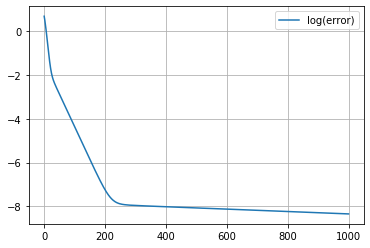

100%|██████████| 1001/1001 [00:06<00:00, 164.96it/s]


In [50]:
for epoch in tqdm.tqdm(range(epochs)):
    
    opts[epoch % len(opts)].zero_grad()
    loss = 0
    
    x_prev, x_cur, x_next = ingrd - DX, ingrd, ingrd + DX
    y_prev, y_cur, y_next = ingrd - DY, ingrd, ingrd + DY
    
    u_x_prev, u_x_cur, u_x_next = net(x_prev), net(x_cur), net(x_next)
    u_y_prev, u_y_cur, u_y_next = net(y_prev), net(y_cur), net(y_next)
    
    du_dx = (u_x_next - u_x_prev) / (2 * d)
    du_dy = (u_y_next - u_y_prev) / (2 * d)
    
    l1 = ((du_dx + du_dy - (2)) ** 2).sum() / x_cur.shape[0]
    l2 = 0
    
    count = 0
    
    for var_name, var_bounds in bounds.items():
        for var_bound, bound_info in var_bounds.items():
            var_ind = bound_info['var_ind']
            var_vls = bound_info['values']
            var_fun = bound_info['func']
            var_grd = bound_info['grid']
            try:
                l2 +=  ((net(var_grd) - var_fun(var_grd[:, var_ind])[:, None]) ** 2).sum()
            except Exception:
                l2 += ((net(var_grd) - var_fun(var_grd[:, var_ind])) ** 2).sum()
            
            count += var_vls.shape[0]
            
    l2 = l2 / count
    loss = l1 + l2
    
    loss.backward()
    opts[epoch % len(opts)].step()
    
    errors += [(l1 + l2).item()]
    
    if plot and epoch % 250 == 0:
        
        clear_output()
        
        plt.plot(np.log10(np.array(errors)), label='log(error)')
        plt.legend()
        plt.grid()
        plt.show()

In [41]:
x = bounds['x']['l']['grid']
y = net(x)
y_= (bounds['x']['l']['func'](x[:, 1]))[:, None]

In [42]:
torch.abs(y - y_).max()

tensor(8.5458e-06, grad_fn=<MaxBackward1>)

In [43]:
x = ingrd
y = net(x)
y_= ((x[:, 0] + x[:, 1]))[:, None]

In [44]:
torch.abs((y - y_)).max()

tensor(8.5458e-06, grad_fn=<MaxBackward1>)

In [45]:
errors[::1000]

[5.048020362854004, 4.927708801005792e-07]